In [1]:
import MNISTtools
import numpy as np
from matplotlib import pyplot as plt

In [2]:
xtrain, ltrain=MNISTtools.load(dataset="training", path="../mnist")

In [3]:
xtrain.shape

(784, 60000)

In [4]:
xtrain.size

47040000

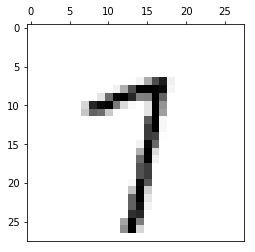

7

In [8]:
MNISTtools.show(xtrain[:,42])
ltrain[42]

In [9]:
def normalize_MNIST_images(x):
    return ((x-127.5)/127.5).astype(np.float64)

In [10]:
def label2onehot(lbl):
    d=np.zeros((lbl.max()+1, lbl.size))
    d[lbl, np.arange(lbl.size)]=1
    return d

dtrain=label2onehot(ltrain)
print(dtrain[:,42])
print(ltrain[42])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


In [11]:
def onehot2label(d):
    lbl=d.argmax(axis=0)
    return lbl

In [12]:
print(all(ltrain==onehot2label(dtrain)))

True


In [13]:
def softmax(a):
    M=a.max(axis=0)
    z=np.exp(a-M)
    return z/z.sum(axis=0)

In [14]:
def softmaxp(a, e):
    return (e-np.sum(softmax(a)*e, axis=0))*softmax(a)

In [15]:
eps=1e-6
a=np.random.randn(10, 200)
e=np.random.randn(10, 200)
diff=softmaxp(a,e)
diff_approx=(softmax(a+eps*e)-softmax(a))/eps
rel_error=np.abs(diff-diff_approx).mean()/np.abs(diff_approx).mean()
print(rel_error, 'should be smaller than 1e-6')

4.894580079275615e-07 should be smaller than 1e-6


In [16]:
def relu(a):
    return (a>0)*a
    
def relup(a, e):
    return (a>0)*e

In [17]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1)   / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni)  / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1)   / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh)  / np.sqrt((Nh+1.))
    return W1, b1, W2, b2

Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)

In [18]:
def forwardprop_shallow(x, net):
    W1=net[0]
    b1=net[1]
    W2=net[2]
    b2=net[3]
    
    a1=W1.dot(x)+b1
    h1=relu(a1)
    a2=W2.dot(h1)+b2
    y=softmax(a2)
    
    return y

xtrain=normalize_MNIST_images(xtrain)
yinit=forwardprop_shallow(xtrain, netinit)

In [19]:
def eval_loss(y, d):
    return -np.sum(d*np.log(y))/d.size

print(eval_loss(yinit, dtrain), 'should be around .26')

0.2939319664114418 should be around .26


In [20]:
def eval_perfs(y, lbl):
    ylabel=onehot2label(y)
    return 100*(ylabel!=lbl).mean()

print(eval_perfs(yinit, ltrain))

90.11666666666667


In [21]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]

    gamma = gamma / x.shape[1]

    a1=W1.dot(x)+b1
    h1=relu(a1)
    a2=W2.dot(h1)+b2
    y=softmax(a2)

    delta2=softmaxp(a2, -d/y)
    delta1=relup(a1, W2.T.dot(delta2))
    
    #경사하강법
    W2=W2-gamma*delta2.dot(h1.T)
    W1=W1-gamma*delta1.dot(x.T)
    b2=b2-gamma*delta2.sum(axis=1, keepdims=True)
    b1=b1-gamma*delta1.sum(axis=1, keepdims=True)
    
    return W1, b1, W2, b2


In [22]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net=update_shallow(x, d, net, gamma)
        predict=forwardprop_shallow(x, net)
        loss=eval_loss(predict, d)
        miss=eval_perfs(predict, lbl)
        print(str(t)+", loss="+str(loss)+", error rate="+str(miss))
    return net

In [29]:
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)

0, loss=0.26942715504817566, error rate=85.80166666666666
1, loss=0.22978220391565157, error rate=83.33
2, loss=0.2096537928797714, error rate=71.75333333333333
3, loss=0.20019335492197035, error rate=66.21666666666667
4, loss=0.1931751029039113, error rate=59.458333333333336
5, loss=0.18692273873004295, error rate=55.18333333333333
6, loss=0.18091064677901472, error rate=51.82333333333333
7, loss=0.17501926577580817, error rate=48.76166666666666
8, loss=0.16919343712798635, error rate=45.82833333333333
9, loss=0.16345891618157543, error rate=43.415
10, loss=0.157904927720347, error rate=41.193333333333335
11, loss=0.15262640923228682, error rate=39.19833333333334
12, loss=0.14760507481640955, error rate=37.62333333333333
13, loss=0.14280733144648872, error rate=36.06333333333333
14, loss=0.13822400474687982, error rate=34.64
15, loss=0.13385209686718075, error rate=33.29666666666667
16, loss=0.12968810668298336, error rate=32.016666666666666
17, loss=0.12573145234185606, error rate=30

In [24]:
xtest, ltest = MNISTtools.load(dataset = "testing", path = "../mnist")
xtest = normalize_MNIST_images(xtest)
dtest = label2onehot(ltest)
print(xtest.shape)
print(ltest.shape)

(784, 10000)
(10000,)


In [25]:
predict = forwardprop_shallow(xtest,nettrain)
loss = eval_loss(predict,dtest)
miss = eval_perfs(predict,ltest)
print(loss)
print(miss)

0.22983651407383482
83.28999999999999


In [33]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05):
    N=x.shape[1]
    NB=int((N+B-1)/B)
    lbl=onehot2label(d)
    for t in range(T):
        shuffled_indices=np.random.permutation(range(N))
        for l in range(NB):
            minibatch_indices=shuffled_indices[B*l:min(B*(l+1), N)]
            index=np.arange(B*l, min(B*(l+1), N))
            net=update_shallow(x[:, index], d[:, index], net, gamma)
        y=forwardprop_shallow(x, net)
        loss=eval_loss(y, d)
        miss=eval_perfs(y, lbl)
        print(str(loss)+" "+str(miss))

    return net

netminibatch=backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100)

0.03066241133439734 9.396666666666667
0.02334410650064302 7.12
0.019318530361918388 5.908333333333333
0.01660705048598481 5.101666666666667
0.014883119948518922 4.585


In [34]:
prd=forwardprop_shallow(xtest, netminibatch)
loss = eval_loss(prd,dtest)
miss = eval_perfs(prd,ltest)
print(loss)
print(miss)

0.015396330490438079
4.8500000000000005
